# 🤖 Proyecto de detección de spam

En este proyecto entrenaremos un modelo de clasificación binaria para que determine si un mensaje de telegram es considerando spam o no, para ello emplearemos técnica de procesamiento de lenguaje natural (NPL).

`@author Daniel Ramírez Vaquero`

`@author Natalie Pilkington`

### Importación de librerías

In [32]:
# %pip install numpy matplotlib pandas scikit-learn seaborn wordcloud

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

## Obtención de datos

Fuentes:
- [telegram-spam-ham(English)](https://huggingface.co/datasets/thehamkercat/telegram-spam-ham/blob/dbf0a97b4b8cb0a8223378c85b6fc7e4526d43fb/dataset.csv)
- [spam_ham_spanish(Español)](https://huggingface.co/datasets/softecapps/spam_ham_spanish)

In [33]:
try:
  english_filepath = 'https://drive.google.com/uc?export=download&id=1K4pBvyxE2U6Bjnk6rOnO-q1cpP2dkIQU'
  spanish_filepath = 'https://drive.google.com/uc?export=download&id=1pZwQ-hftDawo0tmfFsepos8810tcSCrT'
except :
  english_filepath = 'data/english.csv'
  spanish_filepath = 'data/spanish.csv'

english_df = pd.read_csv(english_filepath)
spanish_df = pd.read_csv(spanish_filepath)

## Exploración y visualización de datos

In [34]:
english_df


,text_type,text
0,spam,naturally irresistible your corporate identity...
1,spam,the stock trading gunslinger fanny is merrill ...
2,spam,unbelievable new homes made easy im wanting to...
3,spam,4 color printing special request additional in...
4,spam,do not have money get software cds from here s...
...,...,...
20343,ham,/ban
20344,ham,/ban
20345,ham,/ban
20346,ham,Kaisi hii


Columnas:

- `text_type`: Tiene dos valores *spam* o *ham* si el mensaje es spam o no.
- `text`: Texto del mensaje evaluado.

In [35]:
spanish_df

,mensaje,tipo
0,Compra ahora y recibe un descuento especial,ham
1,Haz clic aqui para ganar un premio,spam
2,Tu ordenador tiene un virus,spam
3,Descubre como perder peso rapidamente,spam
4,Necesitas ayuda con tu tarea,ham
...,...,...
1202,Tu nomina esta disponible para descargar,ham
1203,Baja 2 kilos por semana con nuestra dieta,spam
1204,Elige entre debito o credito,ham
1205,Salva una vida donando sangre hoy,ham


Columnas:

- `tipo`: Tiene dos valores *spam* o *ham* si el mensaje es spam o no.
- `mensaje`: Texto del mensaje evaluado.

Para hacer menos confuso el proceso pondré el mismo nombre a las columnas de ambos dataframes en ingles, las columnas será `type` y `text`.

In [36]:
# Renombro las columnas
spanish_df.rename(columns={'tipo': 'type', 'mensaje': 'text'}, inplace=True)
english_df.rename(columns={'text_type': 'type', 'text': 'text'}, inplace=True)

#Reodeno las columnas
spanish_df = spanish_df[['text', 'type']]
english_df = english_df[['text', 'type']]

In [37]:
english_df.describe()

,text,type
count,20348,20348
unique,20334,2
top,SPAM ALERT 🚔 User: Username: @DillyBubbl...,ham
freq,8,14337


In [38]:
spanish_df.describe()

,text,type
count,1207,1207
unique,1058,2
top,Hola soy tu asesor financiero personal,spam
freq,2,621


In [39]:
english_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20348 entries, 0 to 20347
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20348 non-null  object
 1   type    20348 non-null  object
dtypes: object(2)
memory usage: 318.1+ KB


In [40]:
spanish_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1207 entries, 0 to 1206
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1207 non-null   object
 1   type    1207 non-null   object
dtypes: object(2)
memory usage: 19.0+ KB


Tras esta primera exploración podemos ver que no tenemos valores nulos y que nuestras dos columnas son de timpo `object`(String).

Veamos que proporción tenemos de mensajes de spam y cuanto que no lo son.

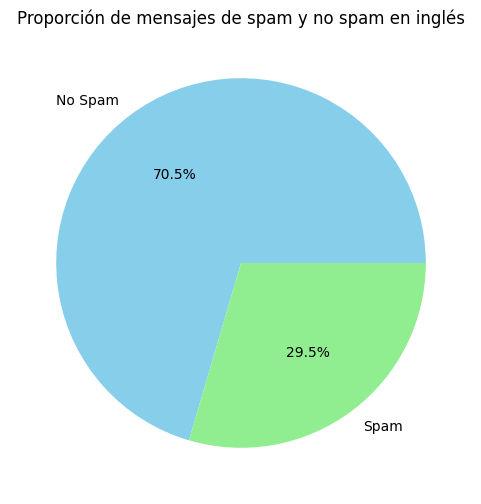

In [41]:
plt.figure(figsize=(6, 6))
english_df['type'].value_counts().rename(index={'spam': 'Spam', 'ham': 'No Spam'}).plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightgreen'])
plt.title('Proporción de mensajes de spam y no spam en inglés')
plt.ylabel('')
plt.show()

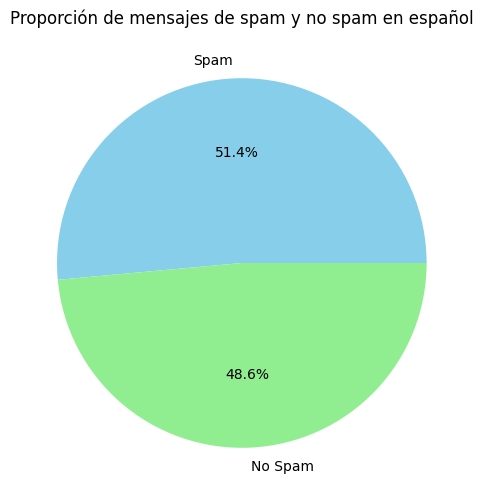

In [42]:
plt.figure(figsize=(6, 6))
spanish_df['type'].value_counts().rename(index={'spam': 'Spam', 'ham': 'No Spam'}).plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightgreen'])
plt.title('Proporción de mensajes de spam y no spam en español')
plt.ylabel('')
plt.show()

Sería interesante ver las palabras más usadas en los mensajes de spam ya que estas nos darán la clave para determinar si el mensaje es spam o no.

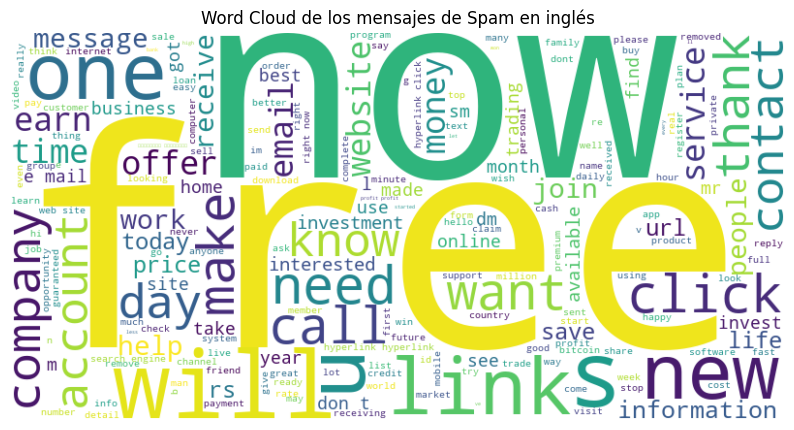

In [43]:
from wordcloud import WordCloud

# Generar el texto de spam
spam_text = ' '.join(english_df[english_df['type'] == 'spam']['text'])

# Crear la nube de palabras con una paleta de colores diferente
spam_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(spam_text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Word Cloud de los mensajes de Spam en inglés')
plt.axis('off')
plt.show()

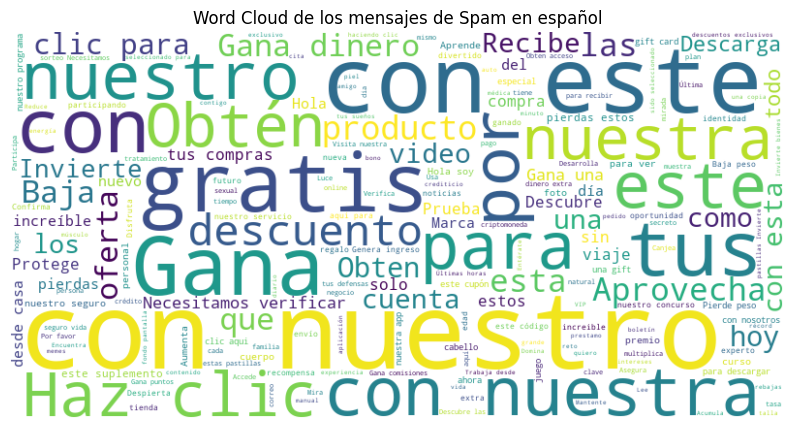

In [44]:
from wordcloud import WordCloud

# Generar el texto de spam
spam_text = ' '.join(
    # Dividir el mensaje en palabras, eliminar palabras con menos de 2 caracteres y unirlas nuevamente
    [' '.join([palabra for palabra in mensaje.split() if len(palabra) > 2])
     for mensaje in spanish_df[spanish_df['type'] == 'spam']['text']]
)

# Crear la nube de palabras con una paleta de colores diferente
spam_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(spam_text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Word Cloud de los mensajes de Spam en español')
plt.axis('off')
plt.show()

Por último podemos ver un histograma comparando la longitud de los mensajes de spam y de no spam.

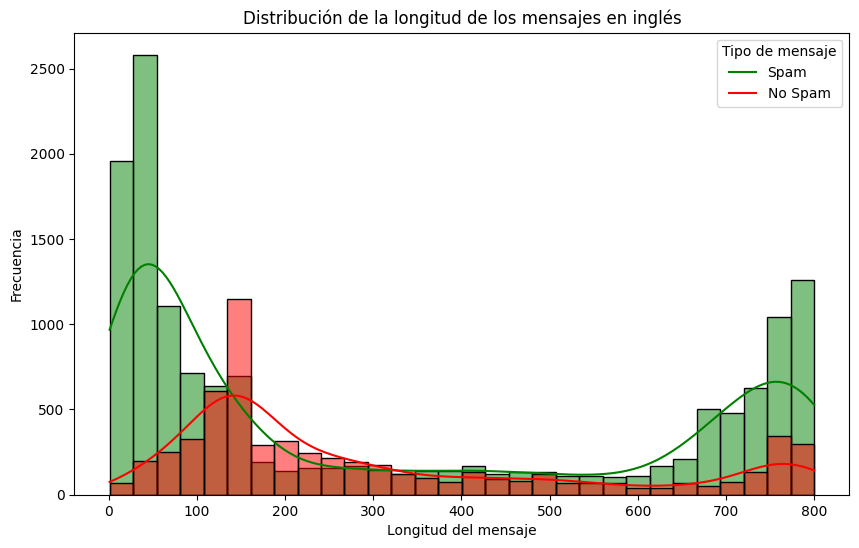

In [45]:
plt.figure(figsize=(10, 6))
sns.histplot(english_df, x=english_df['text'].apply(len), hue='type', bins=30, kde=True, palette={'spam': 'red', 'ham': 'green'})
plt.title('Distribución de la longitud de los mensajes en inglés')
plt.xlabel('Longitud del mensaje')
plt.ylabel('Frecuencia')
plt.legend(title='Tipo de mensaje', labels=['Spam', 'No Spam'])
plt.show()

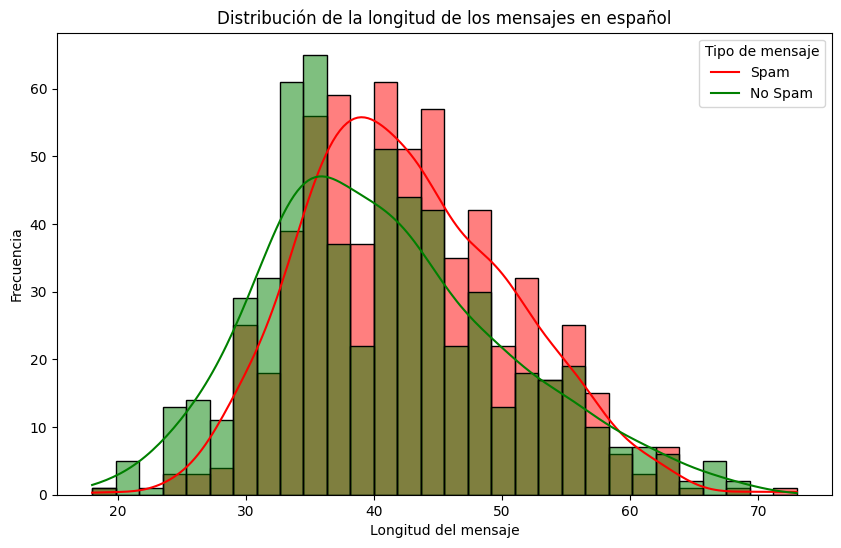

In [46]:
plt.figure(figsize=(10, 6))
sns.histplot(spanish_df, x=spanish_df['text'].apply(len), hue='type', bins=30, kde=True, palette={'spam': 'red', 'ham': 'green'})
plt.title('Distribución de la longitud de los mensajes en español')
plt.xlabel('Longitud del mensaje')
plt.ylabel('Frecuencia')
plt.legend(title='Tipo de mensaje', labels=['Spam', 'No Spam'])
plt.show()

## Preparación de los datos



Cuando se trata de preparar datos de texto hay tres cosas fundamentales que debemos hacer:
- Conversión a minusculas.
- Eliminación de signos de puntuación y carácteres especiales.
- Eliminación de palabras comunes irrelevantes (*stop words*).

#### Conversión a minúsculas

In [47]:
english_df['text'] = english_df['text'].str.lower()
spanish_df['text'] = spanish_df['text'].str.lower()

#### Eliminación de signos de puntuación y caráteres especiales.

In [48]:
import re

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

english_df['text'] = english_df['text'].apply(remove_punctuation)
spanish_df['text'] = spanish_df['text'].apply(remove_punctuation)

#### Eliminación de *'stop words'*

In [49]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Como sklearn no incluye un listado de stop words en español lo haremos nosotros a mano
SPANISH_STOP_WORDS = [
    'de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una',
    'su', 'al', 'es', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'fue', 'este', 'ha', 'sí', 'porque',
    'esta', 'son', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien',
    'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante',
    'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto',
    'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas',
    'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras',
    'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas',
    'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas',
    'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'esté', 'estés', 'estemos', 'estéis', 'estén',
    'estaré', 'estarás', 'estará', 'estaremos', 'estaréis', 'estarán', 'estaría', 'estarías', 'estaríamos',
    'estaríais', 'estarían', 'estaba', 'estabas', 'estábamos', 'estabais', 'estaban', 'estuve', 'estuviste',
    'estuvo', 'estuvimos', 'estuvisteis', 'estuvieron', 'estuviera', 'estuvieras', 'estuviéramos', 'estuvierais',
    'estuvieran', 'estuviese', 'estuvieses', 'estuviésemos', 'estuvieseis', 'estuviesen', 'estando', 'estado',
    'estada', 'estados', 'estadas', 'estad'
]

def remove_stop_words_en(text):
    return ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])

def remove_stop_words_es(text):
    return ' '.join([word for word in text.split() if word not in SPANISH_STOP_WORDS])


english_df['text'] = english_df['text'].apply(remove_stop_words_en)
spanish_df['text'] = spanish_df['text'].apply(remove_stop_words_es)

### Añadido de columna de número de palabras sospechosas

A partir de los wordcoulds sacaremos un listado de palabras sospechosas de pertenecer a un mensaje de spam y procederemos a contar cuantas de estas palabras aparcen en nuestro texto e indicamos el número en una columna.

In [50]:
en_suspicious_words =  [
    "free",
    "promotion",
    "discount",
    "offer",
    "investment",
    "bitcoin",
    "earn",
    "urgent",
    "limited",
    "exclusive",
    "bonus",
    "prize",
    "click here",
    "verification",
    "quick money",
    "guaranteed",
    "confidential",
    "lottery",
    "secure",
    "millionaire"
]

es_suspicious_words = [
    "gratis",
    "promoción",
    "descuento",
    "oferta",
    "inversión",
    "bitcoin",
    "ganar",
    "urgente",
    "limitado",
    "exclusivo",
    "bonificación",
    "premio",
    "clic aquí",
    "clic",
    "click aquí",
    "click",
    "verificación",
    "dinero rápido",
    "garantizado",
    "confidencial",
    "sorteo",
    "seguro",
    "millonario"
]

# Cuento cuantas palabras sospechosas hay en cada fila de ambos df y añado la columna
english_df['suspicious_words'] = english_df['text'].apply(lambda x: sum(1 for word in en_suspicious_words if word in x))
spanish_df['suspicious_words'] = spanish_df['text'].apply(lambda x: sum(1 for word in es_suspicious_words if word in x))

### Vectorización de los textos

Ahora que los datos están limpios vamos a convertirlos en representaciones numéricas para que puedan ser procesados por el modelo, usaremos para ello `TfidfVectorizer`.

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorizador para inglés
vectorizer_en = TfidfVectorizer()
en_vec = vectorizer_en.fit_transform(english_df['text'])  # Transformamos el texto en inglés

# Vectorizador para español
vectorizer_es = TfidfVectorizer()
es_vec = vectorizer_es.fit_transform(spanish_df['text'])  # Transformamos el texto en español

# Guardamos los vectorizadores para futuros usos en joblib
joblib.dump(vectorizer_en, './joblib/vectorizer_en.joblib')
joblib.dump(vectorizer_es, './joblib/vectorizer_es.joblib')

['./joblib/vectorizer_es.joblib']

### Separación de datos de entrenamiento y prueba

In [52]:
from sklearn.model_selection import train_test_split

# Dividir los datos en inglés en entrenamiento y prueba
X_train_en, X_test_en, y_train_en, y_test_en = train_test_split(
    en_vec, english_df['type'], test_size=0.2, random_state=42)

# Dividir los datos en español en entrenamiento y prueba
X_train_es, X_test_es, y_train_es, y_test_es = train_test_split(
    es_vec, spanish_df['type'], test_size=0.2, random_state=42)


## Entrenamiento de los modelos y análisis de rendimiento
Vamos a probar a entrenar nuestro modelo con los 3 algoritmos más usados para este tipo de tarea:

- `RandomForestClassifier`
- `LogisticRegression`
- `MultinomialNB`

Despues veremos el rendimiento de cada uno y nos quedaremos con el mejor.

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import joblib

models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'NaiveBayes': MultinomialNB()
}

# Diccionario para almacenar los resultados
results_en = {}
best_accuracy_en = 0  # Variable para almacenar la mejor precisión
best_model_en = None  # Variable para almacenar el mejor modelo

for model_name, model in models.items():
    # Entrenar el modelo
    model.fit(X_train_en, y_train_en)

    # Realizar predicciones
    y_pred_en = model.predict(X_test_en)

    # Evaluar precisión y otras métricas
    accuracy = accuracy_score(y_test_en, y_pred_en)
    report = classification_report(y_test_en, y_pred_en)

    # Guardar los resultados
    results_en[model_name] = {'accuracy': accuracy, 'report': report}

    print(f"Modelo en Inglés - {model_name}")
    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
    print("="*50)

    # Verificar si este modelo es el mejor
    if accuracy > best_accuracy_en:
        best_accuracy_en = accuracy
        best_model_en = model

# Guardar el mejor modelo en `model_en`
model_en = best_model_en
print("El mejor modelo en inglés es:", model_en)

# Guardar el mejor modelo en un archivo para uso futuro
joblib.dump(model_en, './joblib/best_model_en.joblib')
print("El mejor modelo se ha guardado en 'best_model_en.joblib'")

Modelo en Inglés - RandomForest
Accuracy: 0.9339066339066339
Classification Report:
               precision    recall  f1-score   support

         ham       0.92      0.99      0.96      2913
        spam       0.96      0.80      0.87      1157

    accuracy                           0.93      4070
   macro avg       0.94      0.89      0.91      4070
weighted avg       0.94      0.93      0.93      4070

Modelo en Inglés - LogisticRegression
Accuracy: 0.9208845208845209
Classification Report:
               precision    recall  f1-score   support

         ham       0.92      0.98      0.95      2913
        spam       0.94      0.77      0.85      1157

    accuracy                           0.92      4070
   macro avg       0.93      0.88      0.90      4070
weighted avg       0.92      0.92      0.92      4070

Modelo en Inglés - NaiveBayes
Accuracy: 0.8936117936117937
Classification Report:
               precision    recall  f1-score   support

         ham       0.88      0.9

In [54]:

# Diccionario para almacenar los resultados
results_es = {}
best_accuracy = 0  # Variable para almacenar la mejor precisión
best_model = None  # Variable para almacenar el mejor modelo

for model_name, model in models.items():
    # Entrenar el modelo
    model.fit(X_train_es, y_train_es)

    # Realizar predicciones
    y_pred_es = model.predict(X_test_es)

    # Evaluar precisión y otras métricas
    accuracy = accuracy_score(y_test_es, y_pred_es)
    report = classification_report(y_test_es, y_pred_es)

    # Guardar los resultados
    results_es[model_name] = {'accuracy': accuracy, 'report': report}

    print(f"Modelo en Español - {model_name}")
    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
    print("="*50)

    # Verificar si este modelo es el mejor
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model

# Guardar el mejor modelo en `model_es`
model_es = best_model
print("El mejor modelo en español es:", model_es)

# Guardar el mejor modelo en un archivo para uso futuro
joblib.dump(model_es, './joblib/best_model_es.joblib')
print("El mejor modelo se ha guardado en 'best_model_es.joblib'")



Modelo en Español - RandomForest
Accuracy: 0.9049586776859504
Classification Report:
               precision    recall  f1-score   support

         ham       0.94      0.87      0.90       124
        spam       0.87      0.94      0.91       118

    accuracy                           0.90       242
   macro avg       0.91      0.91      0.90       242
weighted avg       0.91      0.90      0.90       242

Modelo en Español - LogisticRegression
Accuracy: 0.9256198347107438
Classification Report:
               precision    recall  f1-score   support

         ham       0.95      0.90      0.93       124
        spam       0.90      0.95      0.93       118

    accuracy                           0.93       242
   macro avg       0.93      0.93      0.93       242
weighted avg       0.93      0.93      0.93       242

Modelo en Español - NaiveBayes
Accuracy: 0.9380165289256198
Classification Report:
               precision    recall  f1-score   support

         ham       0.92      

Mejores modelos:
- Para english_df `RandomForestClassifier` con **0.93** de acuraccy.
- Para spanish_df `MultinomialNB` con **0.93** de acuraccy.

In [55]:
# Recojo los modelos guardados
model_en = joblib.load('./joblib/best_model_en.joblib')
model_es = joblib.load('./joblib/best_model_es.joblib')

### Matriz de confusión

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Matriz de confusión
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Spam', 'Spam'], yticklabels=['No Spam', 'Spam'])

    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.show()

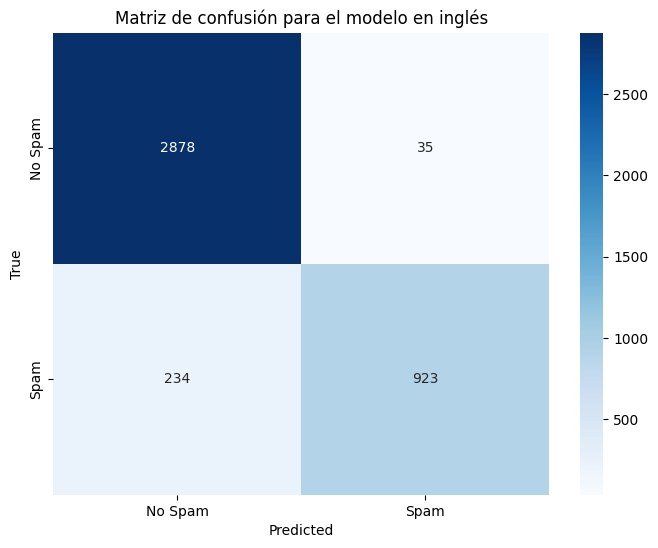

In [57]:
plot_confusion_matrix(y_test_en, model_en.predict(X_test_en), 'Matriz de confusión para el modelo en inglés')

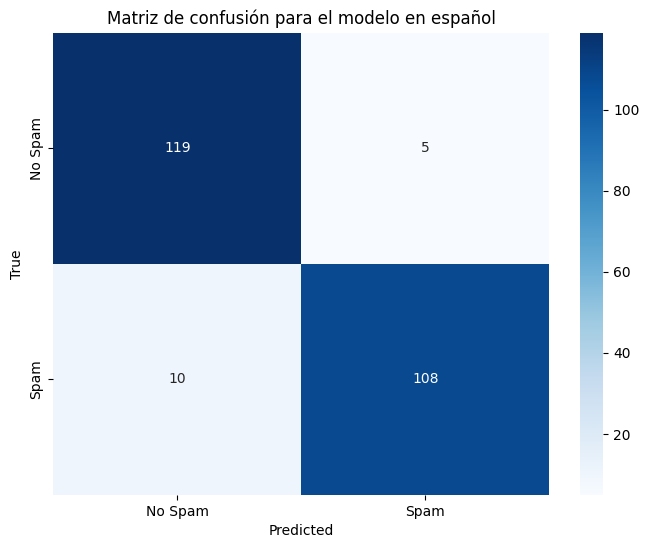

In [58]:
plot_confusion_matrix(y_test_es, model_es.predict(X_test_es), 'Matriz de confusión para el modelo en español')

## Implementación de detección de idiomas.

Como hemos entrenado dos modelos diferentes, uno para español y otro para inglés, necesitamos añadir una capa que nos gestione que modelo usar en función del idioma. Esto lo haremos con el módulo `langdetect`.

In [59]:
%pip install langdetect

from langdetect import detect

def detect_language(text):
    try:
        lang = detect(text)
        return lang  # 'en' para inglés, 'es' para español
    except:
        return 'unknown'

def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Eliminar signos de puntuación y caracteres especiales
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

# Función de predicción final
def predict_spam(message):
    # Preprocesar el mensaje
    message = preprocess_text(message)

    # Detectar el idioma del mensaje
    language = detect_language(message)

    # Seleccionar el modelo y el vectorizador según el idioma
    if language == 'en':
        message_vec = vectorizer_en.transform([message])  # Aplicar vectorizador en inglés
        prediction = model_en.predict(message_vec)  # Usar el modelo en inglés
    elif language == 'es':
        message_vec = vectorizer_es.transform([message])  # Aplicar vectorizador en español
        prediction = model_es.predict(message_vec)  # Usar el modelo en español
    else:
        prediction = ["Idioma desconocido"]  # Devolver un mensaje claro si no se detecta el idioma

    return prediction[0]  # Retorna la predicción (0 para ham, 1 para spam)

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Users\d.ramirez.vaquero\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [60]:
# Ejemplos de prueba
en_spam_msg = "Congratulations! You have been selected to receive an exclusive reward! This is a one-time opportunity to claim a $1000 gift card. To redeem your reward, please click on the link below and fill in your details. Don’t miss out on this limited-time offer! Hurry, only a few rewards left. Click here to claim your prize now!"
es_spam_msg = "¡Felicitaciones! Has sido seleccionado para recibir un premio exclusivo. Esta es una oportunidad única para ganar una tarjeta de regalo de $1000. Para reclamar tu premio, haz clic en el enlace a continuación y completa tus datos. ¡No dejes pasar esta oferta por tiempo limitado! Date prisa, solo quedan unos pocos premios. Haz clic aquí para obtener tu recompensa ahora."
en_ham_msg = "Hey Sarah! Are we still on for the movie tonight? Let me know what time you’ll be ready, and I’ll swing by to pick you up. 😊"
es_ham_msg = "Que pasa Pepe, que tal el dia? Yo por aquí ando liado cuidado a los niños. ¿Te apetece quedar para tomar algo mañana? Venga ya me cuentas."

messages = [
    en_spam_msg,
    es_spam_msg,
    en_ham_msg,
    es_ham_msg
]

for msg in messages:
    print(f"Mensaje: {msg}")
    print(f"Predicción: {predict_spam(msg)}")
    print("="*50)


Mensaje: Congratulations! You have been selected to receive an exclusive reward! This is a one-time opportunity to claim a $1000 gift card. To redeem your reward, please click on the link below and fill in your details. Don’t miss out on this limited-time offer! Hurry, only a few rewards left. Click here to claim your prize now!
Predicción: spam
Mensaje: ¡Felicitaciones! Has sido seleccionado para recibir un premio exclusivo. Esta es una oportunidad única para ganar una tarjeta de regalo de $1000. Para reclamar tu premio, haz clic en el enlace a continuación y completa tus datos. ¡No dejes pasar esta oferta por tiempo limitado! Date prisa, solo quedan unos pocos premios. Haz clic aquí para obtener tu recompensa ahora.
Predicción: spam
Mensaje: Hey Sarah! Are we still on for the movie tonight? Let me know what time you’ll be ready, and I’ll swing by to pick you up. 😊
Predicción: ham
Mensaje: Que pasa Pepe, que tal el dia? Yo por aquí ando liado cuidado a los niños. ¿Te apetece quedar pa